In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 141kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]


In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [10]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [11]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [12]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        scheduler.step()
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    end_time = time.time()
    print(f'\nTotal training time: {end_time - start_time:.2f} seconds')
    return train_losses, train_accs, test_losses, test_accs


In [13]:
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for i, (history, name) in enumerate(zip(histories, model_names)):
        train_losses, train_accs, test_losses, test_accs = history
        epochs = range(1, len(train_losses) + 1)
        axes[0, 0].plot(epochs, train_losses, label=f'{name} Train', marker='o')
        axes[0, 1].plot(epochs, test_losses, label=f'{name} Test', marker='s')
        axes[1, 0].plot(epochs, train_accs, label=f'{name} Train', marker='^')
        axes[1, 1].plot(epochs, test_accs, label=f'{name} Test', marker='v')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    axes[0, 1].set_title('Test Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 1].set_title('Test Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
def visualize_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
    images = images.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(num_samples):
        img = images[i].squeeze()
        img = img * 0.3081 + 0.1307
        img = torch.clamp(img, 0, 1)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {labels[i]}, Pred: {predictions[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [15]:
def plot_model_comparison(histories, model_names):
    final_train_accs = [history[1][-1] for history in histories]
    final_test_accs = [history[3][-1] for history in histories]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    x = np.arange(len(model_names))
    width = 0.35
    ax1.bar(x - width/2, final_train_accs, width, label='Train Accuracy', alpha=0.8)
    ax1.bar(x + width/2, final_test_accs, width, label='Test Accuracy', alpha=0.8)
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Final Model Accuracies')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    for history, name in zip(histories, model_names):
        epochs = range(1, len(history[3]) + 1)
        ax2.plot(epochs, history[3], label=name, marker='o', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy (%)')
    ax2.set_title('Test Accuracy Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [16]:
vgg_model = VGG16(num_classes=10).to(device)
resnet_model = ResNet18(num_classes=10).to(device)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"VGG16 parameters: {count_parameters(vgg_model):,}")
print(f"ResNet18 parameters: {count_parameters(resnet_model):,}")

In [19]:
num_epochs = 2

In [20]:
print("\n"+"="*60)
print("Training VGG16...")
print("="*60)
vgg_history = train_and_evaluate(vgg_model, train_loader, test_loader, num_epochs)



Training VGG16...

Epoch 1/2
------------------------------------------------------------


Evaluating: 100%|██████████| 157/157 [00:59<00:00,  2.62it/s]


Train Loss: 0.8327, Train Acc: 70.40%
Test Loss: 0.2175, Test Acc: 95.60%

Epoch 2/2
------------------------------------------------------------


Evaluating: 100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Train Loss: 0.4697, Train Acc: 85.00%
Test Loss: 0.2524, Test Acc: 92.18%

Total training time: 2267.24 seconds


In [21]:
print("\n" + "="*60)
print("Training ResNet18...")
print("="*60)
resnet_history = train_and_evaluate(resnet_model, train_loader, test_loader, num_epochs)


Training ResNet18...

Epoch 1/2
------------------------------------------------------------


Evaluating: 100%|██████████| 157/157 [00:14<00:00, 10.74it/s]


Train Loss: 0.1138, Train Acc: 96.60%
Test Loss: 0.0803, Test Acc: 97.39%

Epoch 2/2
------------------------------------------------------------


Evaluating: 100%|██████████| 157/157 [00:14<00:00, 10.65it/s]

Train Loss: 0.0436, Train Acc: 98.65%
Test Loss: 0.0412, Test Acc: 98.78%

Total training time: 436.81 seconds


In [22]:
histories = [vgg_history, resnet_history]
model_names = ['VGG16', 'ResNet18']

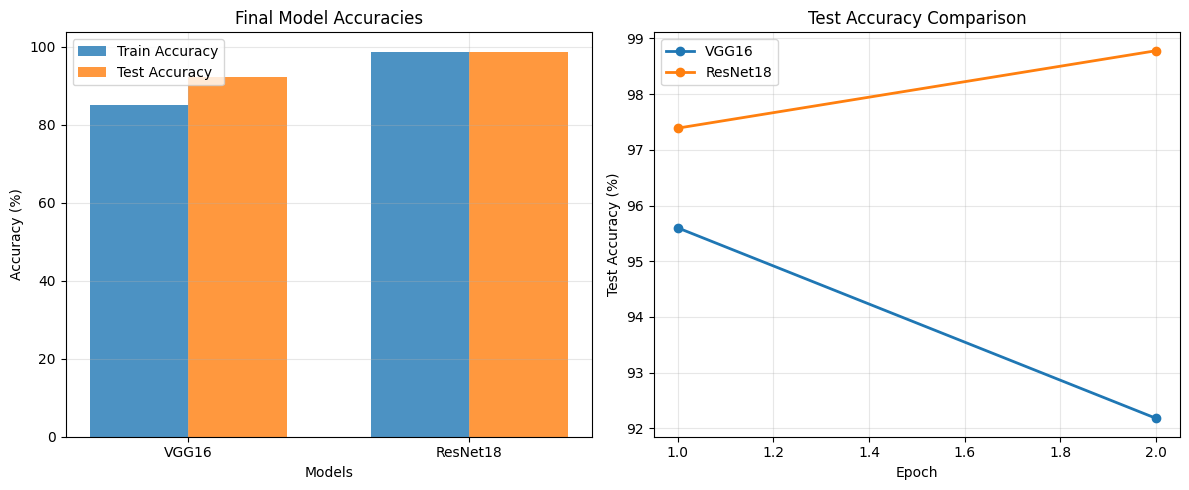

In [24]:
plot_model_comparison(histories, model_names)

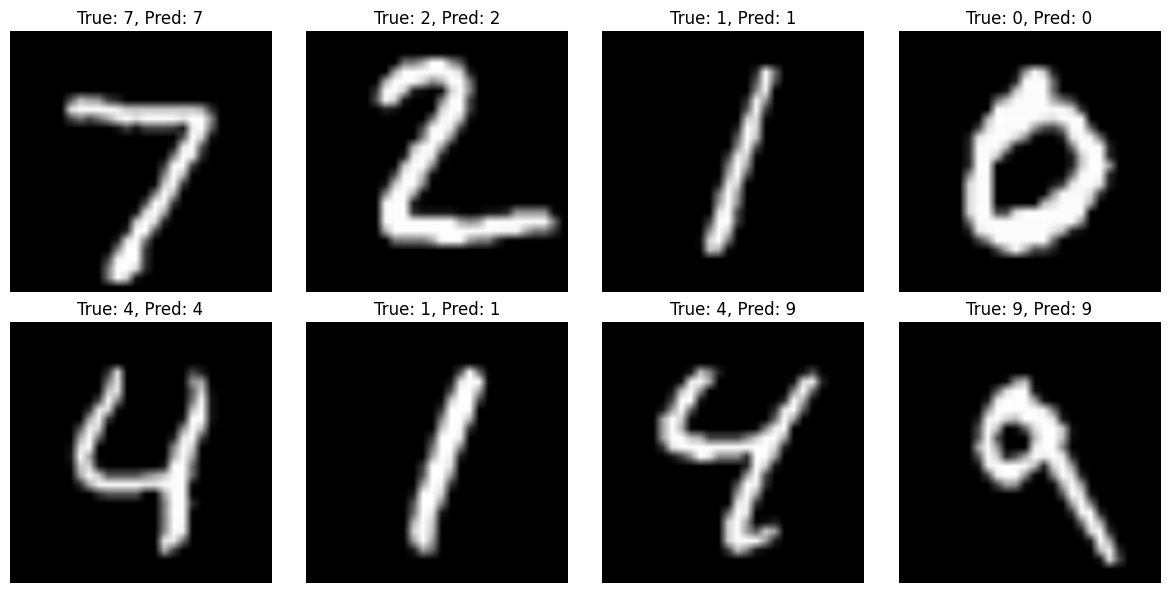

In [25]:
visualize_predictions(vgg_model, test_loader, device)

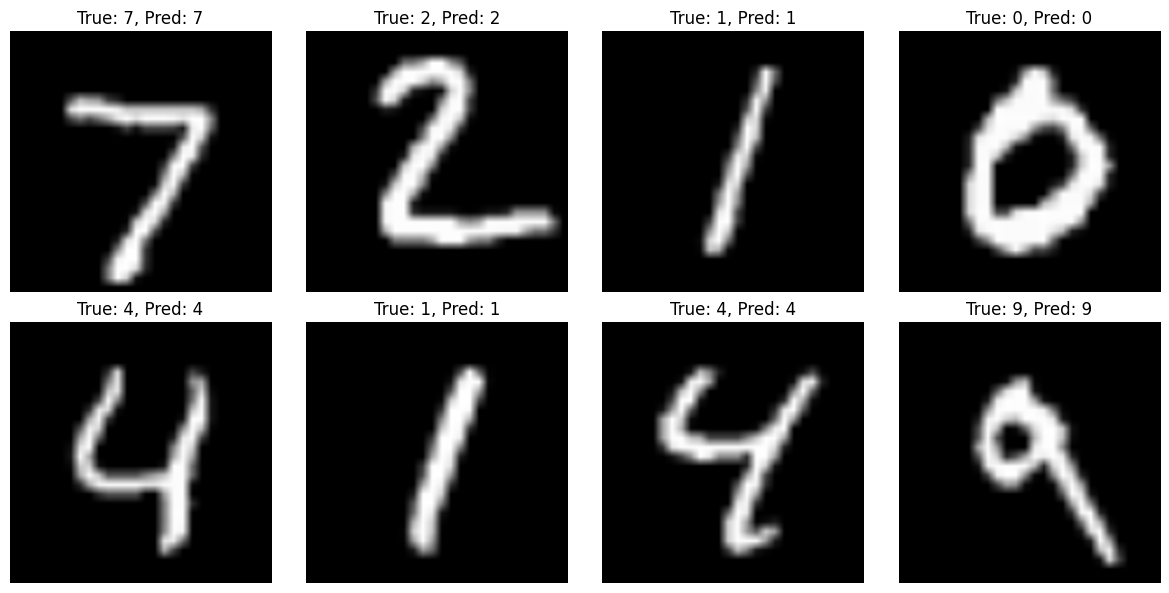

In [26]:
visualize_predictions(resnet_model, test_loader, device)

In [29]:
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

for i, (history, name) in enumerate(zip(histories, model_names)):
    train_losses, train_accs, test_losses, test_accs = history
    print(f"\n{name}:")
    print(f"  Final Train Accuracy: {train_accs[-1]:.2f}%")
    print(f"  Final Test Accuracy: {test_accs[-1]:.2f}%")
    print(f"  Best Test Accuracy: {max(test_accs):.2f}%")


FINAL RESULTS SUMMARY

VGG16:
  Final Train Accuracy: 85.00%
  Final Test Accuracy: 92.18%
  Best Test Accuracy: 95.60%

ResNet18:
  Final Train Accuracy: 98.65%
  Final Test Accuracy: 98.78%
  Best Test Accuracy: 98.78%
